# Applied Data Analysis

## Fall Semester 2016

Team members:
* Stylianos Agapiou (stylianos.agapiou@epfl.ch)
* Athanasios Giannakopoulos (athanasios.giannakopoulos@epfl.ch)
* Dimitrios Sarigiannis (dimitrios.sarigiannis@epfl.ch)

## Project Description

We are given a dataset containing tweets in Switzerland starting from 2010. 

The first goal of the project is to analyse the data and reconstruct mobility flows of the users. More concretely, we try to get insights into high-frequency migration patterns in the swiss territory. The implementation is given in [mobility_patterns](mobility_patterns.ipynb). We also perform data analysis on aggregated data from all years that have been processed in the [mobility_patterns_aggregated](mobility_patterns_aggregated.ipynb) notebook.

The second task of the project is to detect events. Here, we focus on dates and locations of such events. The implementation in given in [event_detection](event_detection.ipynb).

The third and final part of the project deals with sentiment analysis. Here, we focus on the tweets linked to events (as detected in the [event_detection](event_detection.ipynb) notebook) and perform a sentiment analysis for each event. The implementation of the sentiment analysis is given in the [sentiment_analysis](sentiment_analysis.ipynb) notebook.

## Sentiment Analysis
In this part of the project, we use the events detected using DBSCAN in the [event_detection](event_detection.ipynb) task. We keep all tweets that are related to each event and perform sentiment analysis. The sentiment of each tweet is determined using the <code>SentimentIntensityAnalyzer()</code> class of the <code>nltk</code> package. However, two main problems have to be overcome:
* the language of each tweet should be determined
* each tweet should be translated in English before the <code>SentimentIntensityAnalyzer()</code> can be used.
In this notebook, we deal with both problems.

In [1]:
%matplotlib inline
from libraries import *
from utils_event_detection import *
from utils_sentiment_analysis import *
from language_detector import detect_language

### Data Loading

In order to perform the sentiment analysis task, we combine information from two files and create the following dataframes:
* <code>tweets_with_text</code>: contains information related to the tweets (tweet ID, text and date)
* <code>events</code>: contains information about events (location, date, hashtag, etc)

**NOTE:** For 2016, the <code>tweets_with_text_2016.csv</code> file contains a line that prevents the dataset from being loaded sucessfully. We couldn't investigate the problem due to lack of time, therefore, we added the <code>skiprows=[2588468]</code> argument while calling the <code>read_csv()</code> function.

In [2]:
# year to be analyzed
year = '2010'
# file name
file_name = '../../data/tweets_with_text_' + year + '.csv'
# loading data (treating NaN values and datetime format)
tweets_with_text = pd.read_csv(file_name, sep='|', header=None, parse_dates=[2])
# give proper names to columns
tweets_with_text.columns = ['tweetId', 'userId', 'createdAt', 'text']
# create new column with date
tweets_with_text['dayOfTweet'] = tweets_with_text['createdAt'].dt.date.astype('str')
# drop unnecessary columns
tweets_with_text.drop(['createdAt', 'userId'], inplace=True, axis=1)
# display dataframe
tweets_with_text.head()

,tweetId,text,dayOfTweet
0,9514097914,Guuuuten Morgen! :-),2010-02-23
1,9514846412,Still the best coffee in town — at La Stanza h...,2010-02-23
2,9516574359,It has been a week or so.. and today I just co...,2010-02-23
3,9516952605,Getting ready.. http://twitpic.com/14v8gz,2010-02-23
4,9517198943,Un peu de réconfort liquide en take away après...,2010-02-23


Now, we focus on extracting the hashtags from each tweet. This is done in the same way, as in the [event_detection](event_detection.ipynb) task.

In [3]:
tweets_with_text['hashtags'] = tweets_with_text['text'].apply(lambda row: keep_hashtags(row))
# remove rows without hashtags
tweets_with_text.dropna(subset=['hashtags'], inplace=True)

However, it is possible that some tweets contain more than one hashtags. Therefore, we iterate through the <code>tweets_with_text</code> dataframe and duplicate rows that have more than one hashtags.

In [4]:
pairs = []
# iterate through all rows
for _, row in tweets_with_text.iterrows():
    # for each value in the hashtags, create one new row
    for hashtag in row['hashtags']:
        # append the new row to the list
        pairs.append((row['tweetId'], row['text'], row['dayOfTweet'] , hashtag))
# create a new dataframe from the pairs list and give meaningful names to the columns
df = pd.DataFrame(pairs, columns=['tweetId', 'text', 'dayOfTweet', 'hashtag'])
# set tweetId as index
df.set_index('tweetId', inplace=True)

Finally, the hashtags should be preprocessed to avoid mismatches due to case sensitivity. Therefore, everything is converted to lower case and punctuation is removed.

In [5]:
# create a dictionary using a comprehension - this maps every character from string.punctuation to None
# initialize a translation object from it.
translator = str.maketrans({key: None for key in string.punctuation})
# process hashtags
df['hashtag'] = df.apply(lambda row: hashtag_preprocess(row['hashtag'], translator), axis=1)
# display dataframe
df.head()

,text,dayOfTweet,hashtag
tweetId,,,
9519737890,"Magic spells run off after midnight, I guess s...",2010-02-23,#fb
9521789689,"Limitas of public transportation! No taxi, rai...",2010-02-23,#yam
9535390586,"So, Feierabend. Jetzt #24 und später #VfB. — a...",2010-02-23,#24
9535390586,"So, Feierabend. Jetzt #24 und später #VfB. — a...",2010-02-23,#vfb
9536575795,Greetings ! http://tinyurl.com/ycrdlhq #iPhone...,2010-02-23,#iphoneography


Now, we load all events detected using DBSCAN. We keep only events that are considered to be **non spam**, i.e. have more than 1 user.

In [6]:
file_name = '../../data/detected_events_dbscan_' + year + '.csv'
events = pd.read_csv(file_name, sep='|', index_col=[0])
events = events[~events['spamEvent']]
events.head()

,hashtag,dayOfTweet,usersPerHashtag,spamEvent,std,approxLocation
0,#tedxzh,2010-10-20,5,False,178.505886,"('47.383', '8.536')"
1,#gotthard,2010-10-15,4,False,159.250786,"('47.567', '7.597')"
2,#esc,2010-05-29,4,False,61.585952,"('47.162', '8.291')"
3,#fb,2010-10-07,3,False,257.948167,"('46.289', '7.972')"
4,#tedxgeneva,2010-12-06,2,False,153.596919,"('46.194', '6.154')"


### Important Dates and Hashtags

Using the <code>events</code> dataframe, we extract the important days and hashtags, i.e. those that indicate an event.

In [7]:
# keep all hashtags for events
hashtags = events['hashtag'].tolist()
# keep all dates for events
dates = events['dayOfTweet'].tolist()

We use the important <code>hashtags</code> and <code>dates</code> to filter <code>df</code>, i.e. the dataframe with information about the tweets.

In [8]:
# filter dataframe - keep only rows relevant to events
tweets = df[(df['dayOfTweet'].isin(dates)) & (df['hashtag'].isin(hashtags))]
tweets.head()

,text,dayOfTweet,hashtag
tweetId,,,
14993483672,"@adrianbucher ah, jetzt schaust du also auch? ...",2010-05-29,#esc
14993666443,@adrianbucher außer Lena gefällt mir auch nich...,2010-05-29,#esc
14993805773,Die waren doch mal cool! #esc,2010-05-29,#esc
14993864678,"@adrianbucher genau, Public viewing zuhause ;)...",2010-05-29,#esc
14995097955,Griechischer Cowboy! #esc,2010-05-29,#esc


### Language Detection
In order to perform sentiment analysis using the <code>SentimentIntensityAnalyzer</code> class, tweets should be in English. However, most of the tweets in the dataset are in other languages (e.g. French or German). Therefore, we have to detect the tweet language and translate it into English, before moving to the sentiment analysis.

The language detection is done based on a heuristic. We work only with English, German and French. The language of each tweet depends on the number of stopwords of each language that are contained in the tweet text. The tweet language is considered to be equal with the language that gave the highest number of stopwords in the tweet text. This approach may sound naive, however it works really fast, avoids API requests for language detection and gives good results.

The 100% correct language detection is not of our concern. In fact, we use the Yandex API for translation, which auto-detects the language of the input. However, having detected the language of each tweet (even in a wrong way for some tweets) helps in reducing the number of API requests, since text that is already in English should not be traslated.

Nevertheless, the performance of the naive algorithm is decent, as it can be seem from the following output

In [9]:
# detect tweet language
tweets['language'] = tweets.apply(lambda row: detect_language(row['text']), axis=1)
# number of tweets with non-detected language
non_detected = 100.0 * tweets['language'].isnull().sum() / tweets.shape[0]
# drop tweets with non-detected language
tweets.dropna(subset=['language'], inplace=True)
print('Language not detected in {0}% of the tweets'.format(np.round(non_detected)))
print('Number of lines remained: ', tweets.shape[0])
# display dataframe
tweets.head()

Language not detected in 8.0% of the tweets
Number of lines remained:  80


,text,dayOfTweet,hashtag,language
tweetId,,,,
14993483672,"@adrianbucher ah, jetzt schaust du also auch? ...",2010-05-29,#esc,de
14993666443,@adrianbucher außer Lena gefällt mir auch nich...,2010-05-29,#esc,de
14993805773,Die waren doch mal cool! #esc,2010-05-29,#esc,de
14996376751,Jetzt kommt viermal ein cooles Lied! #esc,2010-05-29,#esc,de
14997113097,Ich hab die Haare schön! #esc,2010-05-29,#esc,de


Before moving to the traslation process, we clear the tweet text by removing hashtags (#), URLs and references to other persons (@).

In [10]:
# clean tweet text
tweets['text'] = tweets.apply(lambda row: clean_tweet_text(row['text']), axis=1)

### Sentiment Estimation

Now that we have detected the tweet language and cleaned its text, we move to estimating the compound sentiment score of each tweet. This is done using the <code>SentimentIntensityAnalyzer</code> class of the <code>nltk</code> package. Two steps are required:

1. translating the text from the source language to English
2. estimating the compound sentiment score

The language detection and translation is done using the Yandex translation API. Since we are relying on an API, we have to sample our tweets and perform sentiment analysis on a subset of the data. This is done for two main reasons:
* limitation from the API requests
* time limitations (e.g. the year of 2012 has approx. 140000 entries for translation, which requires more than 10 hours in the promising case of executing 4 requests per second)

In order to avoid the aforementioned problems, we **sample our dataset**, so that the sampled dataset has no more than 5000 tweets for translation. 

Finally, we materialize the final dataframe to avoid future API requests when re-executing the notebook.

In [11]:
print('Number of tweets before sampling: ', tweets.shape[0])
if tweets.shape[0] > 5000:
    tweets = tweets.sample(n=5000, random_state=6)

Number of tweets before sampling:  80


In [12]:
# file name
file_name = '../../data/sentiment_analysis_' + year + '.csv'
# check if file does not exist
if not os.path.isfile(file_name):
    # initialize columns
    tweets['compound'] = np.nan
    tweets['translated'] = 'no'
    # initialize yandex translator object
    with open('yandex.txt', 'r') as input_file:
        KEY = input_file.read().rstrip()
    translate = YandexTranslate(KEY)
    # initialize sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    # translate tweet and estimate compound sentiment score
    tweets = tweets.apply(lambda row: get_sentiment(row, analyzer, translate, debug=True), axis=1)
    # materialize dataframe
    tweets.to_csv(file_name, sep='|')
# check if file exists
else:
    # load file
    tweets = pd.read_csv(file_name, sep='|', index_col=[0])

However, the translation API may not work perfectly for all tweets. Here, we print the number of rows that remain untraslated and have <code>NaN</code> values in the <code>compound</code> column.

In [13]:
print('Total number of tweets: ', tweets.shape[0])
print('Number of non translated tweets: ', tweets[tweets.translated == 'no'].shape[0])
tweets = tweets[tweets['translated'] != 'no']
tweets.head()

Total number of tweets:  80
Number of non translated tweets:  0


,text,dayOfTweet,hashtag,language,compound,translated
tweetId,,,,,,
14993483672,"ah, jetzt schaust du also auch?",2010-05-29,#esc,de,0.4101,yes
14993666443,"außer Lena gefällt mir auch nichts, ist aber w...",2010-05-29,#esc,de,0.8145,yes
14993805773,Die waren doch mal cool!,2010-05-29,#esc,de,0.3802,yes
14996376751,Jetzt kommt viermal ein cooles Lied!,2010-05-29,#esc,de,0.3802,yes
14997113097,Ich hab die Haare schön!,2010-05-29,#esc,de,0.4753,yes


### Event-based Sentiment Analysis

We perform a sentiment analysis for each detected event. We start by projecting the necessary columns of the <code>tweets</code> dataframe and continue by finding the normalized compound sentiment for each event.

In [14]:
# keep necessary columns
tweets = tweets[['hashtag', 'dayOfTweet', 'compound']]
# group by hashtag and date and find normalized compound sentiment score per group
df = tweets.groupby(by=['hashtag', 'dayOfTweet']).apply(normalize_sentiment)
# rename column
df.name = 'compound'
# make dataframe
df = df.reset_index()

In addition, we join the previous dataframe with the <code>events</code> dataframe in order to create a new dataframe with both geolocated information and sentiment score for each event.

In [15]:
# join dataframes 
events_with_sentiment = pd.merge(events, df, left_on=['hashtag', 'dayOfTweet'], 
                                 right_on=['hashtag', 'dayOfTweet'], how='inner')
# display dataframe
events_with_sentiment.head()

,hashtag,dayOfTweet,usersPerHashtag,spamEvent,std,approxLocation,compound
0,#tedxzh,2010-10-20,5,False,178.505886,"('47.383', '8.536')",0.318594
1,#gotthard,2010-10-15,4,False,159.250786,"('47.567', '7.597')",-0.147140
2,#esc,2010-05-29,4,False,61.585952,"('47.162', '8.291')",0.339444
3,#fb,2010-10-07,3,False,257.948167,"('46.289', '7.972')",0.078100
4,#tedxgeneva,2010-12-06,2,False,153.596919,"('46.194', '6.154')",0.326600


Finally, we perform an inverse geolocated query to find the event location given its coordinates. We materialize the result in order to ease any execution of this notebook in the future. Here, we also have restrictions since we use the <code>googlemaps</code> API (limit of 2500 requests/day). Therefore, we check the dimensions of the <code>events_with_sentiment</code> dataframe and create a new dataframe with 2500 rows if necessary.

In [16]:
print(events_with_sentiment.shape[0])
# check number of rows and sample if necessary
if events_with_sentiment.shape[0] > 2500:
    events_with_sentiment = events_with_sentiment.sample(n=2500, random_state=6)

6


In [17]:
# file name
file_name = '../../data/sentiment_analysis_' + year + '_full_info.csv'
# check if file does not exist
if not os.path.isfile(file_name):
    # read key from file
    with open('key.txt', 'r') as input_file:
        KEY = input_file.read().rstrip()
    # initialize googlemaps object
    gmaps = googlemaps.Client(key=KEY)
    # find swiss cantons 
    json_data = pd.read_json('../../data/maps/ch-cantons.topojson.json', typ='dataframe')
    swiss_cantons = [item['id'] for item in json_data['objects']['cantons']['geometries']]
    # find area of event given its location
    events_with_sentiment['area'] = events_with_sentiment.apply(
        lambda row: find_canton_of_event(row['approxLocation'], gmaps, swiss_cantons, debug=True), axis=1)
    # save dataframe
    events_with_sentiment.to_csv(file_name, sep='|')
# check if file exists
else:
    # load existing file
    events_with_sentiment = pd.read_csv(file_name, sep='|', index_col=[0])

The full list of events with their respective sentiment score can be found in the <code>sentiment_analysis_year_full_info.csv</code> files in the <code>data</code> directory.

### Sentiment Analysis Visualization

To conclude our analysis, we visualize the results. We observe that some events happen more than once per year. Therefore, we decide to plot our results in two ways:

* we aggregate the sentiment score based on the hashtag, i.e. the event ID. Hence, we estimate how people think and feel for each particular event.
* we aggregate the sentiment score for all event in a particular area. Hence, we estimate if people feel different about events organized in different locations.

In order to plot the results, two variables should be specified:
* <code>group_by</code>: it is set to either 'hashtag' or 'area' to specify the attribute on which the sentiment score should be aggregated.
* <code>threshold</code>: it indicates the number of points in the x-axis. If <code>group_by = 'hashtag'</code> and <code>threshold = 10</code>, then the x-axis contains the 10 events with the highest number of tweets. If <code>group_by = 'area'</code> and <code>threshold = 5</code>, then the x-axis contains 5 locations with the highest number of tweets.

In order to set these parameters in proper way, we display the number of unique hashtags and areas for each year that is analyzed.

In [18]:
num_hashtags = events_with_sentiment['hashtag'].nunique()
num_areas = events_with_sentiment['area'].nunique()
print('The number of unique hashtags is {}'.format(num_hashtags))
print('The number of unique areas is {}'.format(num_areas))

The number of unique hashtags is 6
The number of unique areas is 6


In [19]:
# set the group_by parameter
group_by = 'hashtag'
# set the threshold parameter
threshold = 10

In order to make use of the aforementioned variables, the following code block should be uncommented. Here, we want to show both plots and therefore do not use the aforementioned parameters.

In [20]:
# grouped_sentiment = group_sentiment_score(by=group_by, data=events_with_sentiment)
# visualize_sentiment_score(data=grouped_sentiment, threshold=threshold, x_axis=group_by)

As mentioned above, a hashtag may appear for more than one dates throughout a year. Therefore, each pair of <code>(hashtag, date)</code> has a particular compound score and number of users. The aggregation on the sentiment score is done based on a weighted sum given by

$$aggregated \ sentiment = \frac{\sum_{i=1}^{k}u_i \cdot s_i}{\sum_{i=1}^{k}u_i}$$

where

* $s_i$ indicates the compound sentiment score for an event on a particular day
* $u_i$ indicates the number of users for an event on a particular day

This is done in order to take into account all the users and their respective opinion for each event on each day.

#### Sentiment Score per Area

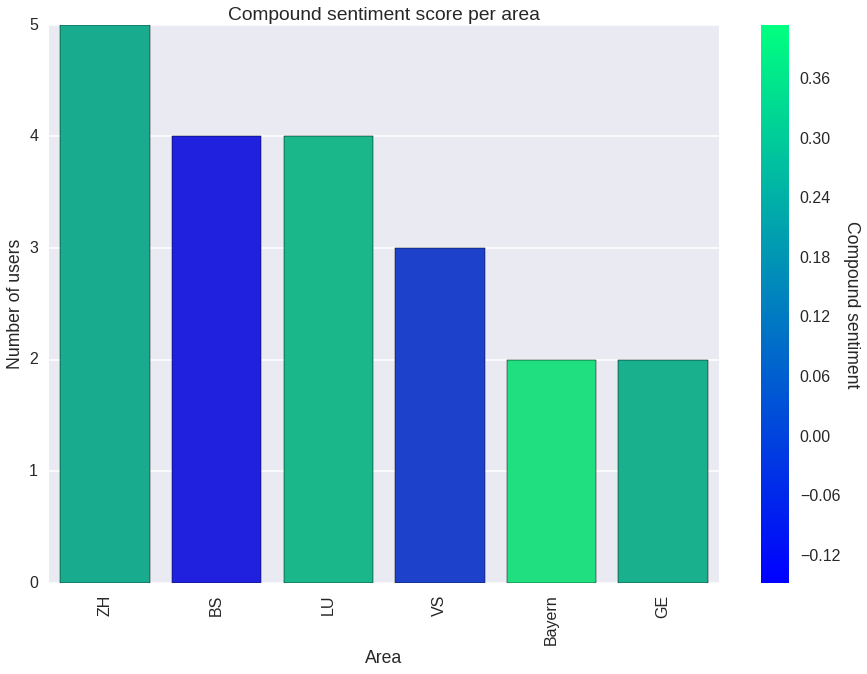

In [21]:
# group sentiment score based on area
grouped_sentiment = group_sentiment_score(by='area', data=events_with_sentiment)
# visualize result
visualize_sentiment_score(data=grouped_sentiment, threshold=10, x_axis='area', year=year)

#### Sentiment Score per Event

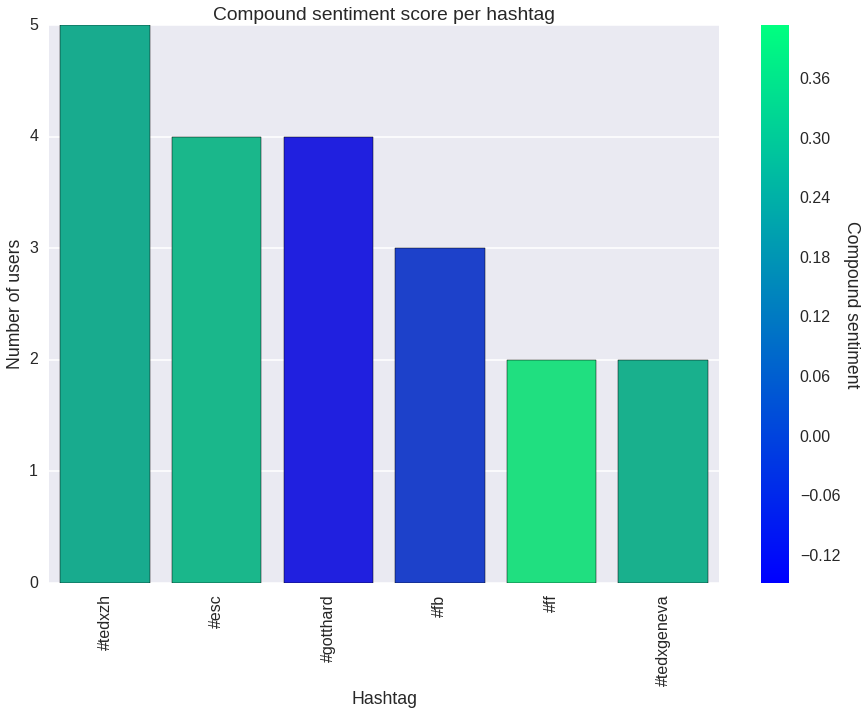

In [22]:
# group sentiment score based on hashtag, i.e. event
grouped_sentiment = group_sentiment_score(by='hashtag', data=events_with_sentiment)
# visualize result
visualize_sentiment_score(data=grouped_sentiment, threshold=15, x_axis='hashtag', year=year)